In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from argparse import Namespace
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from ml.models.transformer import TimeSeriesTransformer
from ml.utils.data_utils import prepare_dataset  # you already have this

In [2]:
# ─────────────────────────────────────────────────────────────
# 1) Config
args = Namespace(
    data_path='../dataset/full_dataset.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,                  # encoder length L
    forecast_steps=6,             # horizon H
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,

    # Model
    d_model=128,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,

    # Train
    epochs=20,
    batch_size=64,
    lr=1e-3,
    weight_decay=0.0,
    grad_clip=1.0,

    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path='transformer_multistep.pt'
)

In [3]:
# ─────────────────────────────────────────────────────────────
# 2) Data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
# X: [N, L, D], y: [N, 6, 5]
input_size  = X_train.shape[2]
output_size = y_train.shape[2]

train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                  torch.tensor(y_train, dtype=torch.float32)),
    batch_size=args.batch_size, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                  torch.tensor(y_test, dtype=torch.float32)),
    batch_size=args.batch_size, shuffle=False
)

In [4]:
# ─────────────────────────────────────────────────────────────
# 3) Model
model = TimeSeriesTransformer(
    input_size=input_size,
    output_size=output_size,
    forecast_steps=args.forecast_steps,
    d_model=args.d_model,
    nhead=args.nhead,
    num_encoder_layers=args.num_encoder_layers,
    num_decoder_layers=args.num_decoder_layers,
    dim_feedforward=args.dim_feedforward,
    dropout=args.dropout,
).to(args.device)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
criterion = nn.MSELoss()

In [5]:
# ─────────────────────────────────────────────────────────────
# 4) Train
best_loss = float('inf')
for epoch in range(1, args.epochs + 1):
    model.train()
    total = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(args.device), yb.to(args.device)
        optimizer.zero_grad()
        preds = model(xb)                 # [B, 6, 5]
        loss = criterion(preds, yb)
        loss.backward()
        if args.grad_clip and args.grad_clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), args.grad_clip)
        optimizer.step()
        total += loss.item()
    print(f"[{epoch}/{args.epochs}] Train Loss: {total/len(train_loader):.4f}")

[1/20] Train Loss: 0.0931
[2/20] Train Loss: 0.0159
[3/20] Train Loss: 0.0141
[4/20] Train Loss: 0.0132
[5/20] Train Loss: 0.0123
[6/20] Train Loss: 0.0118
[7/20] Train Loss: 0.0119
[8/20] Train Loss: 0.0115
[9/20] Train Loss: 0.0114
[10/20] Train Loss: 0.0114
[11/20] Train Loss: 0.0112
[12/20] Train Loss: 0.0110
[13/20] Train Loss: 0.0109
[14/20] Train Loss: 0.0109
[15/20] Train Loss: 0.0110
[16/20] Train Loss: 0.0109
[17/20] Train Loss: 0.0107
[18/20] Train Loss: 0.0108
[19/20] Train Loss: 0.0107
[20/20] Train Loss: 0.0106


In [6]:
# ─────────────────────────────────────────────────────────────
# 5) Save
torch.save(model.state_dict(), args.save_path)
print(f"Saved Transformer model to: {args.save_path}")

Saved Transformer model to: transformer_multistep.pt


In [9]:
# ─────────────────────────────────────────────────────────────
# 6) Evaluate
def _safe_mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def evaluate_all_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    nrmse = rmse / (np.max(y_true) - np.min(y_true) + 1e-8)
    mape = _safe_mape(y_true, y_pred)
    return dict(MSE=mse, RMSE=rmse, MAE=mae, R2=r2, NRMSE=nrmse, MAPE=mape)

model.eval()
with torch.no_grad():
    preds = []
    for xb, _ in test_loader:
        xb = xb.to(args.device)
        preds.append(model(xb).cpu().numpy())
    preds = np.concatenate(preds, axis=0)  # [N, 6, 5]

# Flatten across time to align with your previous evaluation style
preds_flat = preds.reshape(-1, preds.shape[-1])
y_true_flat = y_test.reshape(-1, y_test.shape[-1])

rows = []
print("\nEvaluation (flattened across 6 steps):")
for i, var in enumerate(args.targets):
    m = evaluate_all_metrics(y_true_flat[:, i], preds_flat[:, i])
    rows.append({"Target": var, **m})
    print(f"{var}: " + ", ".join(f"{k}={v:.4f}" for k, v in m.items()))

df_eval = pd.DataFrame(rows)
df_eval


Evaluation (flattened across 6 steps):
rnti_count: MSE=0.0077, RMSE=0.0875, MAE=0.0651, R2=0.5104, NRMSE=0.1223, MAPE=31.6937
rb_down: MSE=0.0120, RMSE=0.1094, MAE=0.0566, R2=0.3659, NRMSE=0.1096, MAPE=67.0958
rb_up: MSE=0.0195, RMSE=0.1396, MAE=0.0769, R2=0.3746, NRMSE=0.1396, MAPE=375056.0988
down: MSE=0.0091, RMSE=0.0952, MAE=0.0576, R2=0.3579, NRMSE=0.0956, MAPE=49.0923
up: MSE=0.0163, RMSE=0.1276, MAE=0.0639, R2=0.3234, NRMSE=0.1276, MAPE=291274.7699


,Target,MSE,RMSE,MAE,R2,NRMSE,MAPE
0,rnti_count,0.007657,0.087502,0.065066,0.510397,0.122285,31.693679
1,rb_down,0.011973,0.109422,0.056570,0.365873,0.109599,67.095843
2,rb_up,0.019485,0.139590,0.076859,0.374593,0.139590,375056.098832
3,down,0.009070,0.095236,0.057571,0.357934,0.095591,49.092330
4,up,0.016291,0.127636,0.063906,0.323450,0.127636,291274.769923



Forecast plots for rb_down


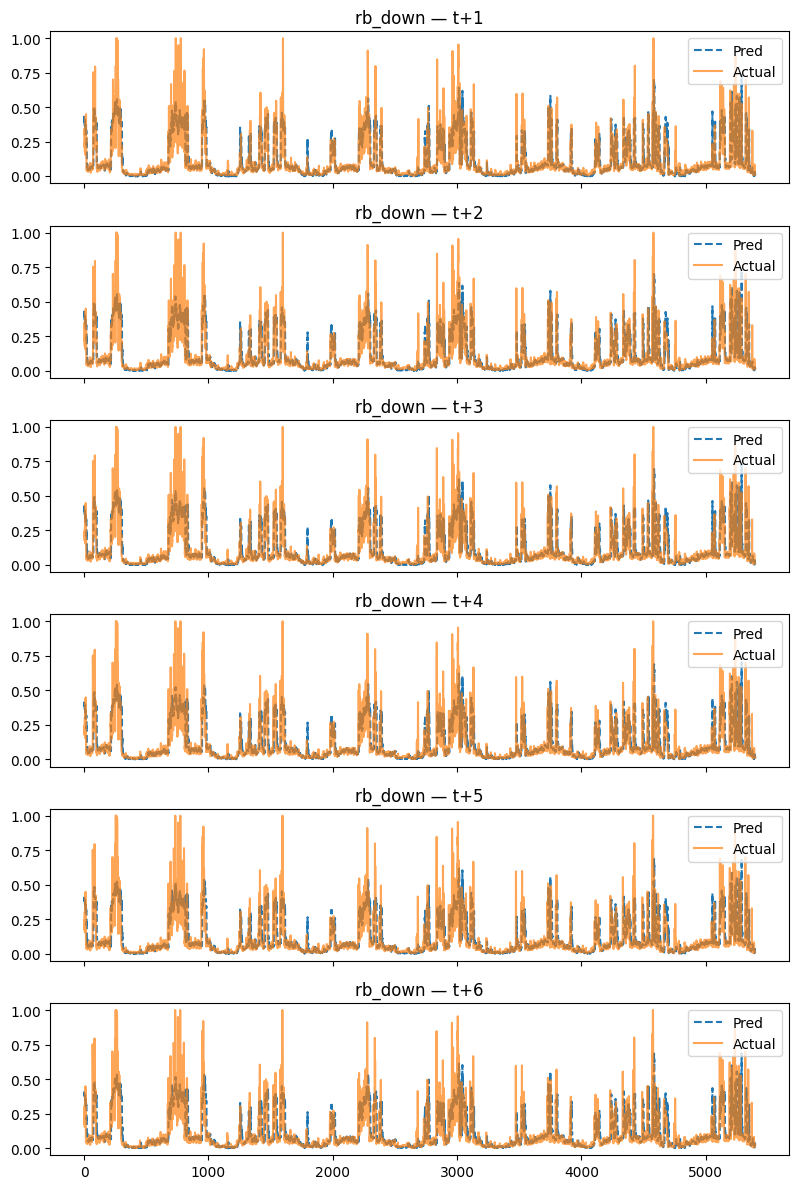

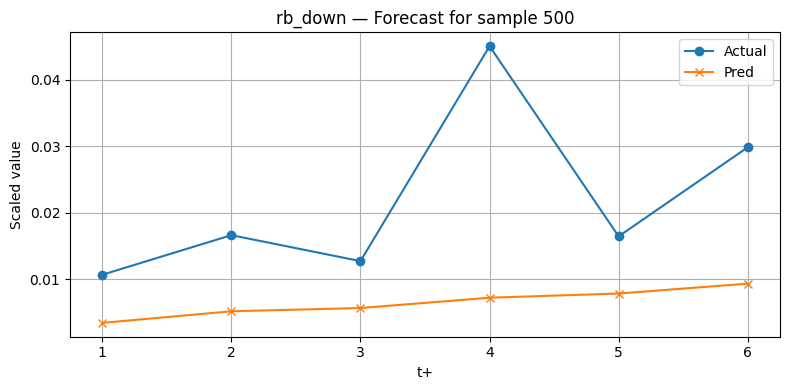


Forecast plots for down


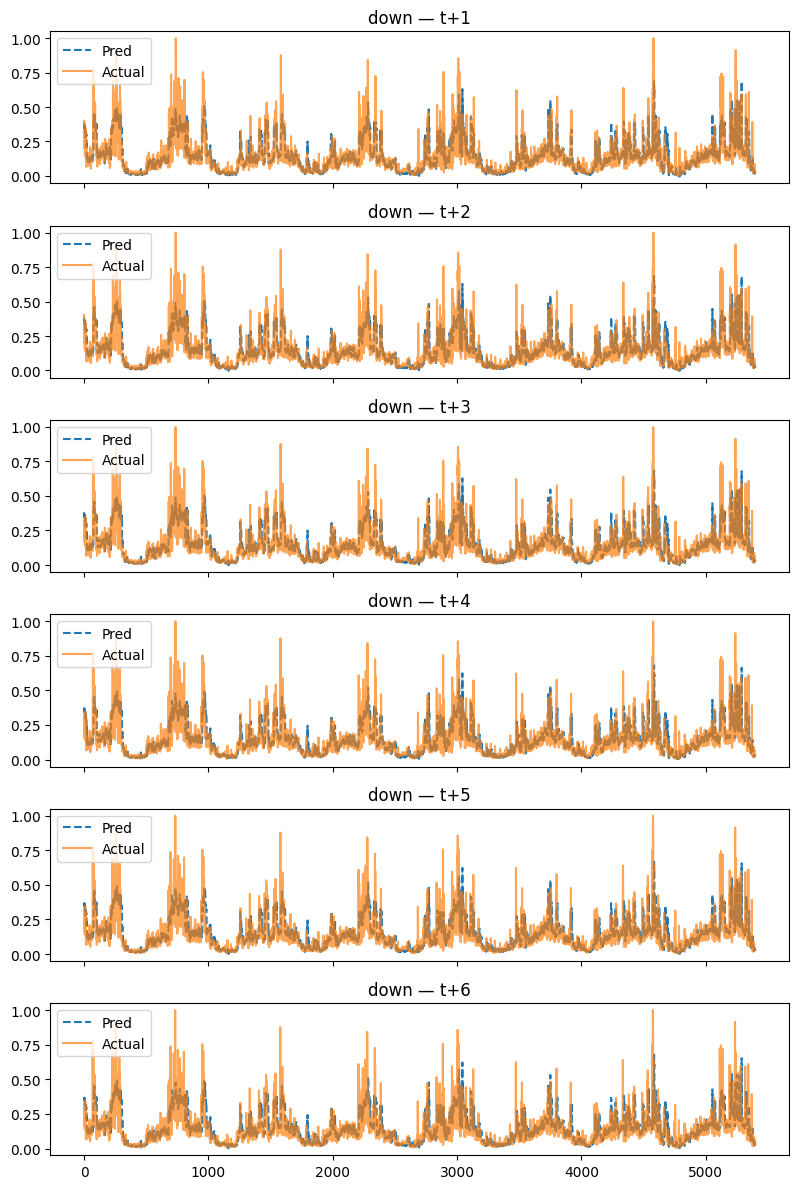

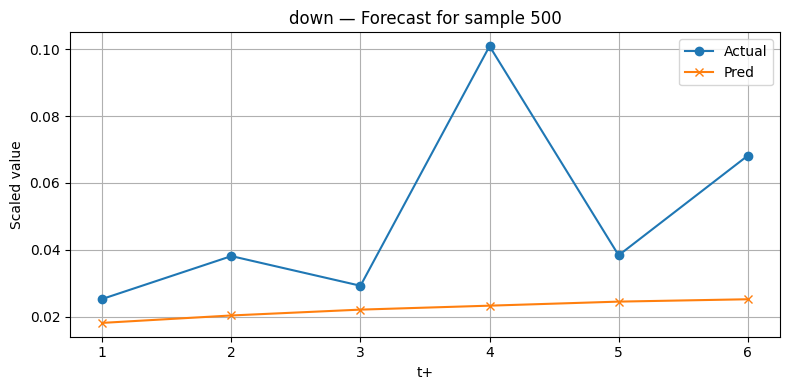

In [8]:
# ─────────────────────────────────────────────────────────────
# 7) Visualizations (same patterns you used before)
def plot_all_steps(preds, y_test, var_name):
    """Plot all 6 horizons as 6 subplots for one variable."""
    idx = args.targets.index(var_name)
    fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
    for t in range(args.forecast_steps):
        axs[t].plot(preds[:, t, idx], label='Pred', linestyle='--')
        axs[t].plot(y_test[:, t, idx], label='Actual', alpha=0.7)
        axs[t].set_title(f"{var_name} — t+{t+1}")
        axs[t].legend()
    plt.tight_layout()
    plt.show()

def plot_sample_steps(preds, y_test, sample_idx, var_name):
    """Plot t+1..t+6 for a single sample for one variable."""
    idx = args.targets.index(var_name)
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, args.forecast_steps+1), y_test[sample_idx, :, idx], label="Actual", marker='o')
    plt.plot(range(1, args.forecast_steps+1), preds[sample_idx, :, idx], label="Pred", marker='x')
    plt.title(f"{var_name} — Forecast for sample {sample_idx}")
    plt.xlabel("t+"); plt.ylabel("Scaled value")
    plt.xticks(range(1, args.forecast_steps+1))
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.show()

for var in ['rb_down', 'down']:
    print(f"\nForecast plots for {var}")
    plot_all_steps(preds, y_test, var)
    plot_sample_steps(preds, y_test, sample_idx=500, var_name=var)